# Preparing the environment

In [10]:
from bandits import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from IPython.core.pylabtools import figsize

> **Note** :
> The experiments done in this notebook may not be **samely reproducible** as we do not specify a fixed seed for 
> `numpy.random`.

# Analyzing the UCB algorithm

- First let's create an instance of a `Casino`. It will have 10 machines each with a randomly generated payoff. These payoffs will be the same for all the following experiments, meaning only one instance of `Casino` will be used.
- Once this is done, we can create an instance of UCB that will use the created casino for the calculations.

In [17]:
casino = Casino(nb=10)
ucb = UCB(casino)

Let's get the best confidence value for the UCB. We can do that by trying different values of confidence between 0.1 and 1.0 each one multiple times, calculate the mean and drw the corresponding curve. We will repeat UCB on each confidence value 50 times before calculating the mean so that the value does not get biaised as the casino machines use probabilities to return rewards.

  0%|          | 0/450 [00:00<?, ?it/s]

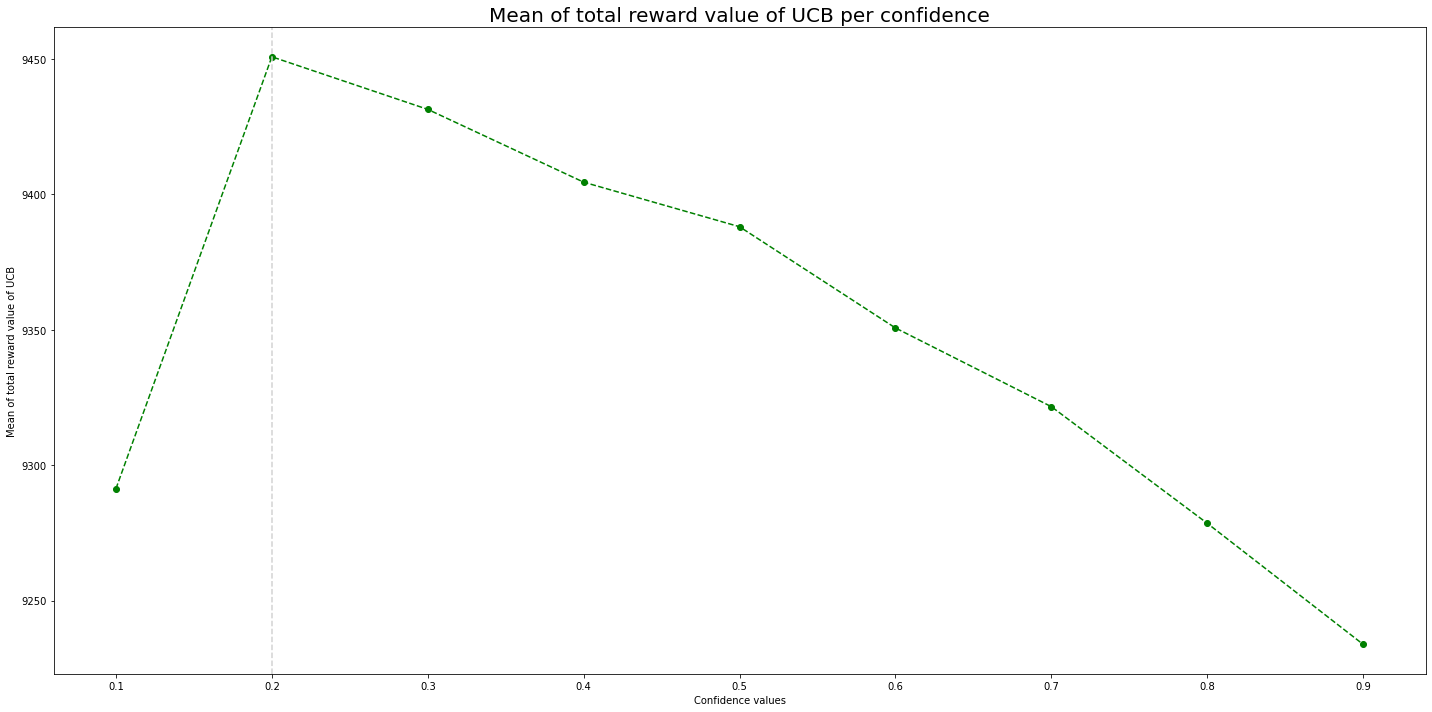

In [72]:
confidence_values = np.arange(0.1, 1.0, 0.1)
total_rewards = []
repetition = 50
with tqdm(total=len(confidence_values) * repetition) as pbar:
    for c in range(len(confidence_values)):
        reward = 0
        for i in range(repetition):
            reward += ucb.doUCB(confidence_values[c])
            ucb.initialize()
            pbar.update(1)
        total_rewards.append(reward / repetition)


fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Mean of total reward value of UCB")
ax.set_xlabel("Confidence values")
ax.set_title("Mean of total reward value of UCB per confidence", fontsize=20)
plt.plot(confidence_values, total_rewards, marker="o", linestyle="--", color="g")
ax.axvline(
    x=confidence_values[np.argmax(total_rewards)], linestyle="--", color="lightgrey"
)
fig.tight_layout()

The curve shows the value of confidence that gave the maximum mean total reward is 0.2. We will be using this value from now on.

In [13]:
confidence = 0.2

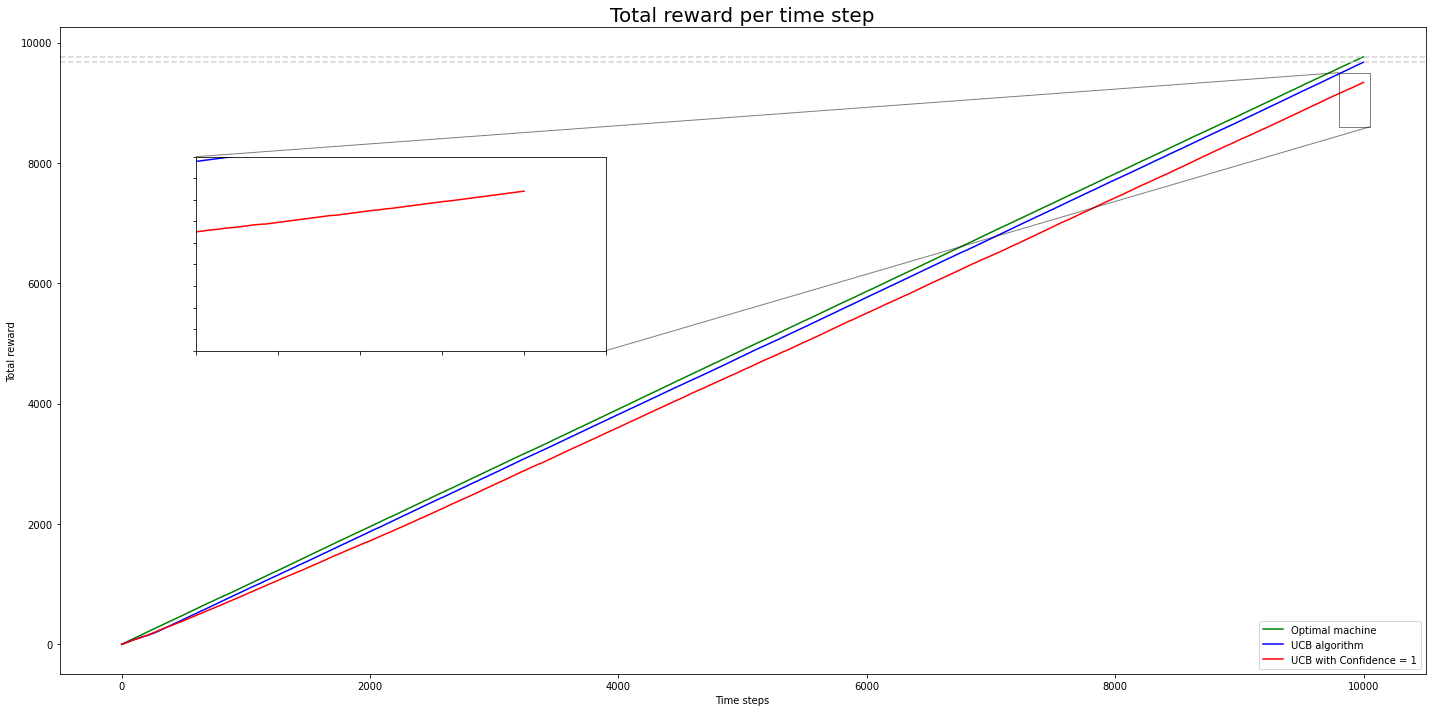

In [16]:
ucb.initialize()
time_steps = []
ucb_rewards_per_time = []
optimal_rewards_per_time = []
reward, time_step = ucb.doOneStepUCB(confidence)
while reward is not None:
    time_steps.append(time_step)
    ucb_rewards_per_time.append(reward)
    optimal_rewards_per_time.append(casino.realBestChoice().playIt())
    reward, time_step = ucb.doOneStepUCB(confidence)

ucb.initialize()
ucb_with_full_confidence = []
reward, time_step = ucb.doOneStepUCB(1)
while reward is not None:
    ucb_with_full_confidence.append(reward)
    reward, time_step = ucb.doOneStepUCB(1)

cumulative_ucb_rewards_per_time = np.cumsum(ucb_rewards_per_time)
cumulative_optimal_rewards_per_time = np.cumsum(optimal_rewards_per_time)
cumulative_ucb_with_full_confidence = np.cumsum(ucb_with_full_confidence)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Total reward")
ax.set_xlabel("Time steps")
ax.set_title("Total reward per time step", fontsize=20)
plt.plot(
    time_steps, cumulative_optimal_rewards_per_time, color="g", label="Optimal machine"
)
plt.plot(time_steps, cumulative_ucb_rewards_per_time, color="b", label="UCB algorithm")
plt.plot(
    time_steps,
    cumulative_ucb_with_full_confidence,
    color="r",
    label="UCB with Confidence = 1",
)
ax.axhline(y=np.max(cumulative_ucb_rewards_per_time), linestyle="--", color="lightgrey")
ax.axhline(
    y=np.max(cumulative_optimal_rewards_per_time), linestyle="--", color="lightgrey"
)
ax.legend()

axins = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
axins.plot(
    time_steps, cumulative_ucb_rewards_per_time, color="b", label="UCB algorithm"
)
axins.plot(
    time_steps, cumulative_optimal_rewards_per_time, color="g", label="Optimal machine"
)
axins.plot(
    time_steps,
    cumulative_ucb_with_full_confidence,
    color="r",
    label="UCB with Confidence = 1",
)
# sub region of the original image
x1, x2, y1, y2 = 9800, 10050, 8600, 9500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

fig.tight_layout()

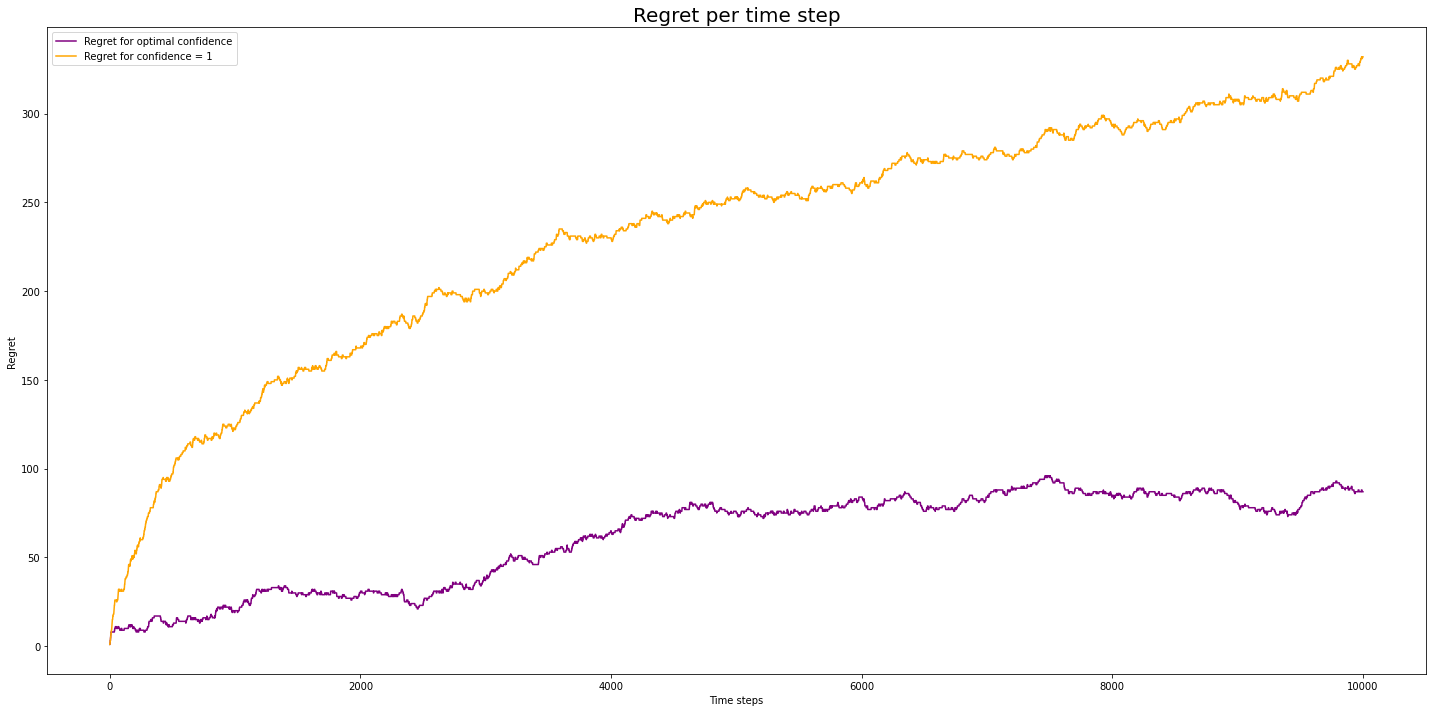

In [11]:
regret_1 = cumulative_optimal_rewards_per_time - cumulative_ucb_rewards_per_time
regret_2 = cumulative_optimal_rewards_per_time - cumulative_ucb_with_full_confidence
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Regret")
ax.set_xlabel("Time steps")
ax.set_title("Regret per time step", fontsize=20)
plt.plot(time_steps, regret_1, color="purple", label="Regret for optimal confidence")
plt.plot(time_steps, regret_2, color="orange", label="Regret for confidence = 1")

ax.legend()
fig.tight_layout()

# Improving the UCB algorithm

The mehtod is inspired by the work in [this paper](http://personal.unileoben.ac.at/rortner/Pubs/UCBRev.pdf).